In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import cv2 as cv

In [2]:
X = np.load('Transfer_dataset_X.npy', allow_pickle=True)
y = np.load('Transfer_dataset_y.npy', allow_pickle=True)

In [3]:
X.shape

(10000, 224, 224, 3)

In [4]:
X[0].shape

(224, 224, 3)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=711)

In [6]:
del X
del y

In [10]:
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [8]:
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) 
x = Dense(128, activation='relu')(x) 
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x) 


# define formal model object to train and compile 
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics='BinaryAccuracy')



2021-11-24 10:13:43.112034: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/cv2/../../lib64:
2021-11-24 10:13:43.112055: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-24 10:13:43.112069: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (StephenB): /proc/driver/nvidia/version does not exist
2021-11-24 10:13:43.112179: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# model.summary()
# EarlyStopping(patience=8, verbose=1, restore_best_weights=True),

In [10]:
model_output= model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.25,
                       callbacks=[ReduceLROnPlateau(factor=.5, patience=3, verbose=1)])

2021-11-24 10:13:44.014081: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3612672000 exceeds 10% of free system memory.
2021-11-24 10:13:44.926870: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 0.4134 - binary_accuracy: 0.9107

2021-11-24 10:14:28.602282: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1204224000 exceeds 10% of free system memory.


94/94 [==============================] - 59s 612ms/step - loss: 0.4134 - binary_accuracy: 0.9107 - val_loss: 0.1732 - val_binary_accuracy: 0.9505
Epoch 2/20
94/94 [==============================] - 57s 613ms/step - loss: 0.1135 - binary_accuracy: 0.9643 - val_loss: 0.1965 - val_binary_accuracy: 0.9440
Epoch 3/20
94/94 [==============================] - 58s 617ms/step - loss: 0.0790 - binary_accuracy: 0.9735 - val_loss: 0.1070 - val_binary_accuracy: 0.9690
Epoch 4/20
94/94 [==============================] - 58s 615ms/step - loss: 0.0519 - binary_accuracy: 0.9832 - val_loss: 0.1317 - val_binary_accuracy: 0.9560
Epoch 5/20
94/94 [==============================] - 58s 615ms/step - loss: 0.0456 - binary_accuracy: 0.9835 - val_loss: 0.1737 - val_binary_accuracy: 0.9590
Epoch 6/20
94/94 [==============================] - 58s 619ms/step - loss: 0.0336 - binary_accuracy: 0.9878 - val_loss: 0.1111 - val_binary_accuracy: 0.9705

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.000500000

In [13]:
from sklearn.metrics import accuracy_score
preds = np.round(model.predict(X_test))
accuracy_score(y_test, preds)

2021-11-24 10:48:55.388502: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1204224000 exceeds 10% of free system memory.


0.9705

In [14]:
model.save('transfer_model.h5')

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [12]:
transfer_model = load_model('transfer_model.h5')

2021-11-29 10:58:52.731123: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1204224000 exceeds 10% of free system memory.
2021-11-29 10:58:53.070398: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


0.9705

In [13]:
from sklearn.metrics import accuracy_score
preds = np.round(transfer_model.predict(X_test))
accuracy_score(y_test, preds)

2021-11-29 10:59:17.548193: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1204224000 exceeds 10% of free system memory.


0.9705

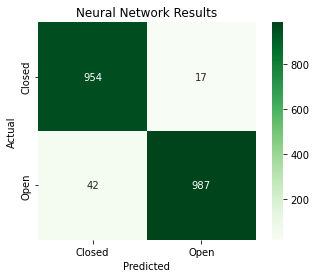

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_confusion = confusion_matrix(y_test, preds)
sns.heatmap(test_confusion, cmap="Greens", annot=True, square=True,fmt='g',
            xticklabels=['Closed', 'Open'], 
            yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Neural Network Results');
plt.savefig("Transfer_Confusion_Matrix.png")
